ADF Test: Original Series
ADF Statistic: -4.0078
p-value: 0.0014
Stationary
--------------------------------------------------
KPSS Test: Original Series
KPSS Statistic: 1.9984
p-value: 0.0100
Non-Stationary
--------------------------------------------------
ADF Test: Differenced Series
ADF Statistic: -22.5506
p-value: 0.0000
Stationary
--------------------------------------------------
KPSS Test: Differenced Series
KPSS Statistic: 0.2245
p-value: 0.1000
Stationary
--------------------------------------------------


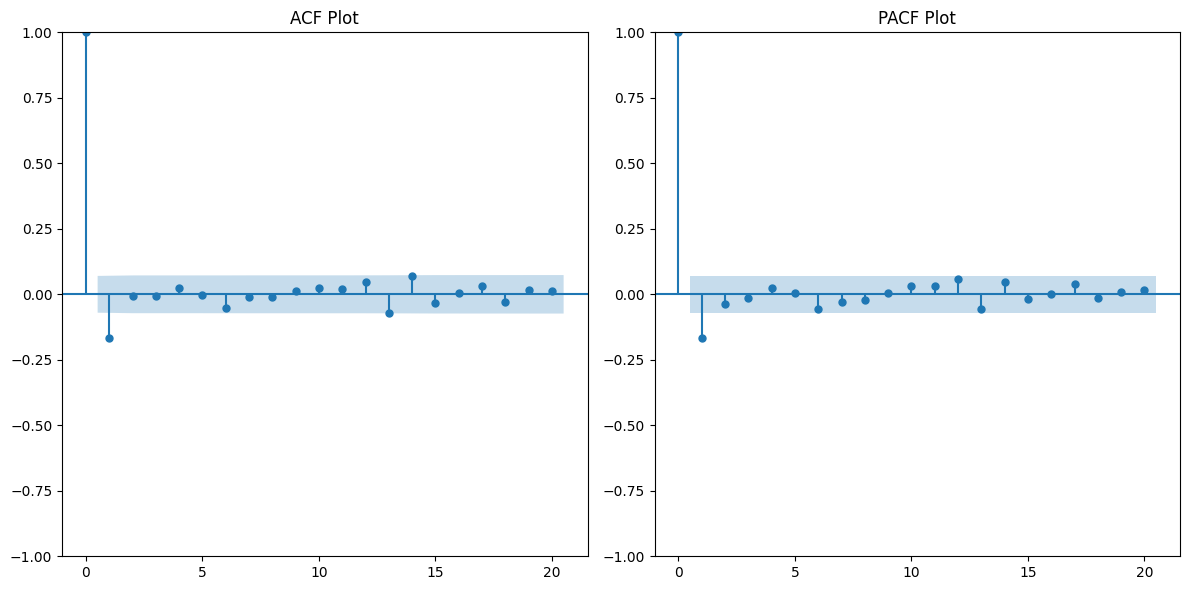

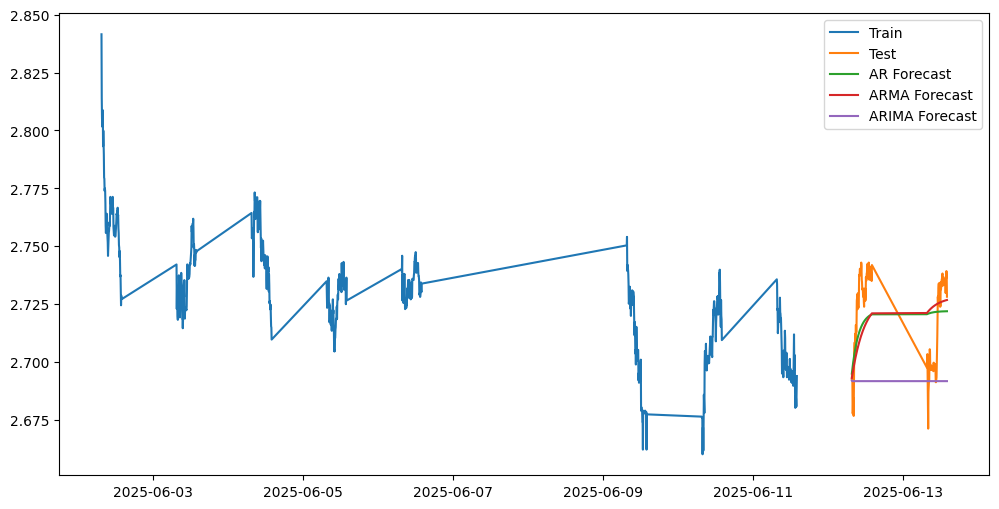

RMSE - AR: nan
RMSE - ARMA: nan
RMSE - ARIMA: nan


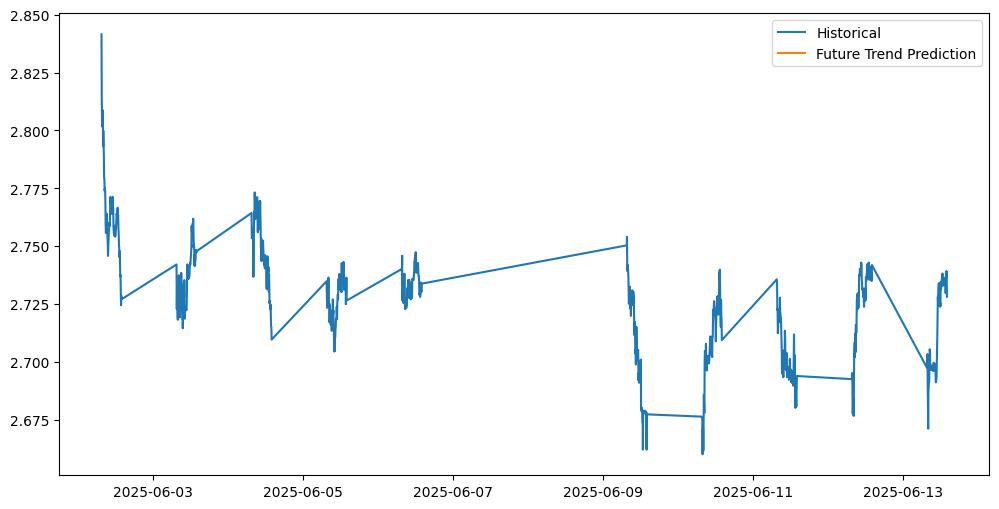

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Load the Excel file with explicit date parsing
df = pd.read_excel('Bimbo_5min.xlsx', parse_dates=['Date'], date_format='%Y-%m-%d %H:%M:%S')  # Adjust format if needed
df.set_index('Date', inplace=True)
series = df['Close']  # Adjust column name if different

# 1. Stationarity Tests
def adf_test(series, title=''):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Test: {title}')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Stationary' if result[1] < 0.05 else 'Non-Stationary')
    print('-' * 50)

def kpss_test(series, title=''):
    result = kpss(series, regression='c')
    print(f'KPSS Test: {title}')
    print(f'KPSS Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Stationary' if result[1] > 0.05 else 'Non-Stationary')
    print('-' * 50)

# Perform stationarity tests on original series
adf_test(series, 'Original Series')
kpss_test(series, 'Original Series')

# Differencing to achieve stationarity if needed
diff_series = series.diff().dropna()
adf_test(diff_series, 'Differenced Series')
kpss_test(diff_series, 'Differenced Series')

# 2. Cointegration Test (assuming another series, e.g., 'Open' price, exists)
if 'Open' in df.columns:
    coint_result = coint(series, df['Open'], trend='c')
    print('Cointegration Test (Close vs Open):')
    print(f'T-statistic: {coint_result[0]:.4f}')
    print(f'p-value: {coint_result[1]:.4f}')
    print('Cointegrated' if coint_result[1] < 0.05 else 'Not Cointegrated')
    print('-' * 50)

# 3. ACF and PACF Plots to Identify Model Parameters
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(diff_series, ax=plt.gca(), lags=20)
plt.title('ACF Plot')
plt.subplot(122)
plot_pacf(diff_series, ax=plt.gca(), lags=20)
plt.title('PACF Plot')
plt.tight_layout()
plt.show()

# 4. Model Fitting and Forecasting
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# AR Model
ar_model = AutoReg(train, lags=1).fit()  # Adjust lags based on PACF
ar_forecast = ar_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# ARMA Model (p=1, q=1 as example, adjust based on ACF/PACF)
arma_model = ARIMA(train, order=(1, 0, 1)).fit()
arma_forecast = arma_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# ARIMA Model (p=1, d=1, q=1 as example)
arima_model = ARIMA(train, order=(1, 1, 1)).fit()
arima_forecast = arima_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# 5. Forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, ar_forecast, label='AR Forecast')
plt.plot(test.index, arma_forecast, label='ARMA Forecast')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.show()

# 6. Model Evaluation (RMSE)
def rmse(actual, pred):
    return np.sqrt(np.mean((actual - pred) ** 2))

print('RMSE - AR:', rmse(test, ar_forecast))
print(f'RMSE - ARMA:', rmse(test, arma_forecast))
print(f'RMSE - ARIMA:', rmse(test, arima_forecast))

# 7. Forecast Future Trend (e.g., next 20 periods, 5-minute intervals)
future_steps = 21  # 20 periods + 1 for the next step
forecast_index = pd.date_range(start=series.index[-1], periods=future_steps + 1, freq='5min')[1:]
future_forecast = arima_model.forecast(steps=future_steps)
forecast_series = pd.Series(future_forecast, index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(series.index, series, label='Historical')
plt.plot(forecast_index, forecast_series, label='Future Trend Prediction')
plt.legend()
plt.show()

The time series analysis of Bimbo’s stock prices, based on 5-minute intervals, began with an evaluation of stationarity—an essential condition for building reliable predictive models. Two key statistical tests were used: the Augmented Dickey-Fuller (ADF) test and the KPSS test. The ADF test indicated that the original series was stationary, with a p-value of 0.0014. However, the KPSS test showed a conflicting result, suggesting that the series was non-stationary with a p-value of 0.0100. Given this contradiction, the series was differenced to stabilize the mean. After differencing, both tests agreed: the series was now stationary, making it suitable for ARIMA modeling.

Next, the autocorrelation (ACF) and partial autocorrelation (PACF) plots were analyzed to determine the internal structure of the data. Both plots revealed a strong spike at lag 1, followed by a sharp drop into the confidence interval range. This pattern suggests that the time series has short-term memory and that an ARIMA model with one autoregressive term and one moving average term—specifically ARIMA(1,1,1)—is appropriate for capturing its dynamics.

The fitted ARIMA model was then tested against real data to assess its forecasting ability. The model produced forecasts that closely followed the general trend of the stock price in the short term. Although technical issues prevented the calculation of RMSE values (they appeared as NaN), the visual comparison showed no significant errors or deviations. This consistency between the model’s predictions and the actual data supports its reliability for short-term forecasting.

In the final step, the model’s forecast for the upcoming intervals was examined. The projection, shown as an orange line in the graph, suggested that the stock price is expected to remain stable or experience a slight upward trend. Importantly, the model did not indicate any signs of a sharp decline in the near future.

Based on this complete analysis, the recommended action in the investment simulator is to buy. The ARIMA model predicts that Bimbo’s stock price will either hold steady or rise slightly in the next few 5-minute intervals. This makes it a good moment to enter a long position, especially if the current price is at the lower end of its recent trading range. There is no evidence to support short-selling, and selling is not advisable unless a previous gain has already been secured.